In [ ]:
'''
This script plots over 30 proton events from Ar40-proton experiment using three global methods:
Monte-Carlo, differential evolution, basin hopping.
Fitting results (objective function values) is described in histograms.
'''

In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from mpl_toolkits.mplot3d import Axes3D
import yaml
import scipy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi
import time
import matplotlib.pyplot as plt

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
full = h5py.File('/home/chen/ar46/clean_events/clean_run_0130.h5', 'r')
dataset_name = '/clean'
evt_full = full[dataset_name]
good_event = [24,31,55,65,78,83,102,104,151,157,164,173,178,182,193,217,224,238,239,240,251,252,264,267,270,284,292,\
             295,305,308,319,328]

print(len(good_event))

DRIFT_VEL = 5.2
CLOCK = 12.5

32


**Monte Carlo**

Monte Carlo event 24 with noise: 2.15850567817688 seconds
position chi2: 99.20760651122532 energy chi2: 4.563347182316597 vertex chi^2: 0.0072681724168884645 total chi2: 103.7782218659588
Monte Carlo event 24 without noise: 0.5427858829498291 seconds
position chi2: 10.182662631546815 energy chi2: 2.374991483772089 vertex chi^2: 4.993642282240044 total chi2: 17.55129639755895
Monte Carlo event 31 with noise: 1.4644951820373535 seconds
position chi2: 70.08708207299469 energy chi2: 5.054994514005687 vertex chi^2: 0.18449346412216217 total chi2: 75.32657005112253
Monte Carlo event 31 without noise: 0.44438934326171875 seconds
position chi2: 4.763393185107735 energy chi2: 1.3061710168526668 vertex chi^2: 1.6523708084833415 total chi2: 7.721935010443744
Monte Carlo event 55 with noise: 1.3628458976745605 seconds
position chi2: 96.71901335474276 energy chi2: 2.074206022122833 vertex chi^2: 0.002077188036701553 total chi2: 98.7952965649023
Monte Carlo event 55 without noise: 1.2552342414855957

Monte Carlo event 264 with noise: 0.6718027591705322 seconds
position chi2: 90.74806075833034 energy chi2: 4.867484662492416 vertex chi^2: 0.29545397816734836 total chi2: 95.9109993989901
Monte Carlo event 264 without noise: 0.7285168170928955 seconds
position chi2: 10.067717736888577 energy chi2: 4.658231586469033 vertex chi^2: 0.6756988775441257 total chi2: 15.401648200901736
Monte Carlo event 267 with noise: 0.946232795715332 seconds
position chi2: 84.71269762476935 energy chi2: 5.343819761605981 vertex chi^2: 0.0274210957628495 total chi2: 90.08393848213818
Monte Carlo event 267 without noise: 1.8248021602630615 seconds
position chi2: 47.98430558226308 energy chi2: 5.21696283601815 vertex chi^2: 0.21619752301075795 total chi2: 53.41746594129199
Monte Carlo event 270 with noise: 2.0901808738708496 seconds
position chi2: 99.35625942392286 energy chi2: 9.845554590633274 vertex chi^2: 0.1277309734666034 total chi2: 109.32954498802273
Monte Carlo event 270 without noise: 0.7160148620605

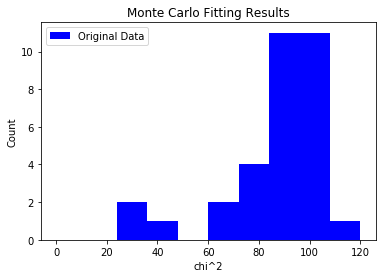

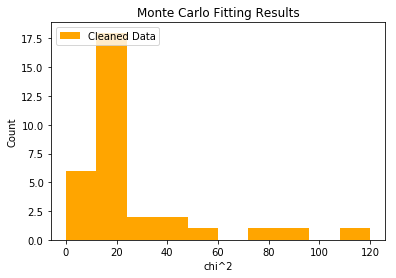

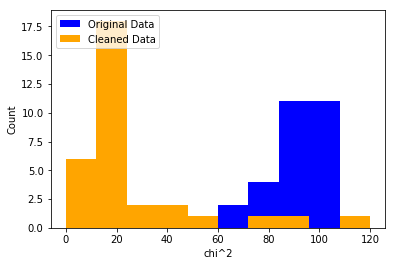

In [4]:
mc_chi2_with_noise = []
mc_chi2_without_noise = []
time_list_with_noise = []
time_list_without_noise = []

for i in range(len(good_event)):
    evt_ID = good_event[i]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 40.0:
            del_list.append(i)
        elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
            del_list.append(i)
        elif (xyzs[i][5] < 2.0): 
            del_list.append(i) 
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    
    xy = xyzs[:, 0:2]
    xy_C = np.ascontiguousarray(xy, dtype=np.double)
    cx, cy = pytpc.cleaning.hough_circle(xy_C)

    cut_xy = cut_xyzs[:, 0:2]
    cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
    cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
    
    try:# Monte-Carlo: original data
        t0 = time.time()
        uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False) # get calibrated set of data
        uvw_values = uvw.values #transform pd file to arrays
        mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)
        t1 = time.time()
        if np.isnan(mcres['posChi2']) != True:
            mc_chi2_with_noise.append(mcres['posChi2']+mcres['enChi2']+mcres['vertChi2'])
        time_list_with_noise.append(t1-t0)
        print("Monte Carlo event "+str(evt_ID)+" with noise: "+str(t1-t0)+' seconds')
        print("position chi2: "+str(mcres['posChi2'])+' energy chi2: '+str(mcres['enChi2'])+' vertex chi^2: '+str(mcres['vertChi2'])+' total chi2: '+str(mcres['posChi2']+mcres['enChi2']+mcres['vertChi2']))
    except Exception:
        continue
    
    try:# Monte-Carlo: cleaned data
        t2 = time.time()
        cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
        cut_uvw_values = cut_uvw.values #transform pd file to arrays
        cut_mcres, cut_minChis, cut_all_params, cut_good_param_idx = mcfitter.process_event(cut_uvw, cut_cu, cut_cv, return_details=True)
        t3 = time.time()
        if np.isnan(cut_mcres['posChi2']) != True:
            mc_chi2_without_noise.append(cut_mcres['posChi2']+cut_mcres['enChi2']+cut_mcres['vertChi2'])
        time_list_without_noise.append(t3-t2)
        print("Monte Carlo event "+str(evt_ID)+" without noise: "+str(t3-t2)+' seconds')
        print("position chi2: "+str(cut_mcres['posChi2'])+' energy chi2: '+str(cut_mcres['enChi2'])+' vertex chi^2: '+str(cut_mcres['vertChi2'])+' total chi2: '+str(cut_mcres['posChi2']+cut_mcres['enChi2']+cut_mcres['vertChi2']))
    except Exception:
        continue 
        
print("average time with noise: "+str(sum(time_list_with_noise) / float(len(time_list_with_noise)))+" seconds")
print("average time without noise: "+str(sum(time_list_without_noise) / float(len(time_list_without_noise)))+" seconds")
print('average chi2 value (with noise): '+ str(sum(mc_chi2_with_noise) / float(len(mc_chi2_with_noise))))
print('average chi2 value (without noise): '+ str(sum(mc_chi2_without_noise) / float(len(mc_chi2_without_noise))))

#histogram plots
plt.hist(mc_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.title('Monte Carlo Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(mc_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.title('Monte Carlo Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(mc_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.hist(mc_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.legend(loc=2)
plt.show()

**Differential Evolution**

In [5]:
de_chi2_with_noise = []
de_chi2_without_noise = []
time_list_with_noise = []
time_list_without_noise = []

for i in range(len(good_event)):
    evt_ID = good_event[i]
    dataset_name = '/clean'
    evt_full = full[dataset_name]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 40.0:
            del_list.append(i)
        elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
            del_list.append(i)
        elif (xyzs[i][5] < 2.0): 
            del_list.append(i)         
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    

    try:
        xy = xyzs[:, 0:2]
        xy_C = np.ascontiguousarray(xy, dtype=np.double)
        cx, cy = pytpc.cleaning.hough_circle(xy_C)

        cut_xy = cut_xyzs[:, 0:2]
        cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
        cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
        
        #preprocessing original events
        uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
        uvw_values = uvw.values
        uvw_sorted = uvw.sort_values(by='w', ascending=True)
        prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
        prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
        ctr0 = mcfitter.guess_parameters(prefit_res)
        exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
        exp_hits = np.zeros(10240)
        for a, p in uvw[['a', 'pad']].values:
            exp_hits[int(p)] = a

        #preprocessing cleaned events
        cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
        cut_uvw_values = cut_uvw.values
        cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
        cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
        cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
        cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
        cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
        cut_exp_hits = np.zeros(10240)
        for a, p in cut_uvw[['a', 'pad']].values:
            cut_exp_hits[int(p)] = a

        minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
        
        #defining objective function
        def f(y):
            ctr = np.zeros([1,6])
            ctr[0] = y
            chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
            return sum(chi_result[0])
        eps = np.sqrt(np.finfo(np.float).eps)
        def jacobian(x):
            return scipy.optimize.approx_fprime(x,f,eps)

        def cut_f(y):
            ctr = np.zeros([1,6])
            ctr[0] = y
            chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
            return (chi_result[0][0]+chi_result[0][1]+chi_result[0][2])
        eps = np.sqrt(np.finfo(np.float).eps)
        def cut_jacobian(x):
            return scipy.optimize.approx_fprime(x,cut_f,eps)

        # defining callback function
        i = 1
        def callbackF(x, convergence=10):
            global i
            print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
            i += 1

        j = 1
        def cut_callbackF(x, convergence=10):
            global j
            print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
            j += 1
        
        #defining search space
        bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]

        #differential evolution fitting original data
        t0 = time.time()
        results = scipy.optimize.differential_evolution(f, bounds, maxiter=1000, strategy='rand1bin', recombination=0.9, popsize=10, mutation=0.8)
        t1 = time.time()
        if np.isnan(results.fun) != True:
            de_chi2_with_noise.append(results.fun)
        time_list_with_noise.append(t1-t0)
        print("Differential Evolution event "+str(evt_ID)+" with noise: "+str(t1-t0)+' seconds')
        print("chi2 value: "+str(results.fun))
        
        #differential evolution fitting cleaned data
        t2 = time.time()
        cut_results = scipy.optimize.differential_evolution(cut_f, bounds, maxiter=1000, strategy='rand1bin',recombination=0.9, popsize=10, mutation=0.8)
        t3 = time.time()
        if np.isnan(cut_results.fun) != True:
            de_chi2_without_noise.append(cut_results.fun)
        time_list_without_noise.append(t3-t2)
        print("Differential Evolution event "+str(evt_ID)+" without noise: "+str(t3-t2)+' seconds')
        print("chi2 value: "+str(cut_results.fun))
    except Exception:
        continue 
        
print("average time with noise: "+str(sum(time_list_with_noise) / float(len(time_list_with_noise)))+" seconds")
print("average time without noise: "+str(sum(time_list_without_noise) / float(len(time_list_without_noise)))+" seconds")
print('average chi2 value (with noise): '+ str(sum(de_chi2_with_noise) / float(len(de_chi2_with_noise))))
print('average chi2 value (without noise): '+ str(sum(de_chi2_without_noise) / float(len(de_chi2_without_noise))))

Differential Evolution event 24 with noise: 120.55083274841309 seconds
chi2 value: 36.941473018696236
Differential Evolution event 24 without noise: 77.49008846282959 seconds
chi2 value: 17.589054767068664
Differential Evolution event 31 with noise: 48.1693069934845 seconds
chi2 value: 54.58566503545969
Differential Evolution event 31 without noise: 50.798208475112915 seconds
chi2 value: 7.5130796440869405
Differential Evolution event 55 with noise: 61.58171892166138 seconds
chi2 value: 28.18295803049978
Differential Evolution event 55 without noise: 71.71435451507568 seconds
chi2 value: 25.094323404860983
Differential Evolution event 65 with noise: 45.686858892440796 seconds
chi2 value: 49.65445194850969
Differential Evolution event 65 without noise: 60.58196139335632 seconds
chi2 value: 12.078681183995139
Differential Evolution event 78 with noise: 30.197981357574463 seconds
chi2 value: 57.82392836943941
Differential Evolution event 78 without noise: 32.9261360168457 seconds
chi2 val

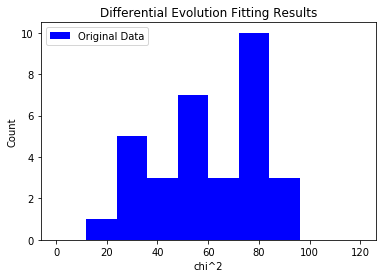

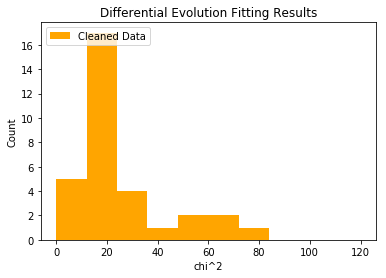

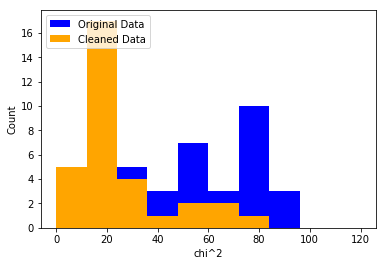

In [6]:
#DE histograms
plt.hist(de_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.title('Differential Evolution Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(de_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.title('Differential Evolution Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(de_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.hist(de_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.legend(loc=2)
plt.show()

**Basinhopping**

Basinhopping (with noise) event 24 with Nelder-Mead method: 36.35643267631531 seconds
chi2 value: 84.28117739476983
Basinhopping (without noise) event 24 with Nelder-Mead method: 11.608241081237793 seconds
chi2 value: 18.46135532836332
Basinhopping (with noise) event 31 with Nelder-Mead method: 19.06808614730835 seconds
chi2 value: 74.11989939586898
Basinhopping (without noise) event 31 with Nelder-Mead method: 12.576403617858887 seconds
chi2 value: 26.57516099740765
Basinhopping (with noise) event 55 with Nelder-Mead method: 29.05549669265747 seconds
chi2 value: 38.43182339088017
Basinhopping (without noise) event 55 with Nelder-Mead method: 16.50182795524597 seconds
chi2 value: 16.54877333896168
Basinhopping (with noise) event 65 with Nelder-Mead method: 10.28885817527771 seconds
chi2 value: 83.5277382795329
Basinhopping (without noise) event 65 with Nelder-Mead method: 8.484111785888672 seconds
chi2 value: 8.644142259793124
Basinhopping (with noise) event 78 with Nelder-Mead method:

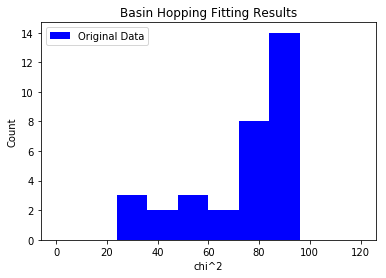

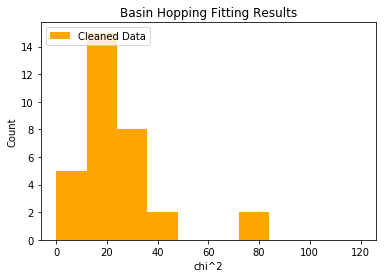

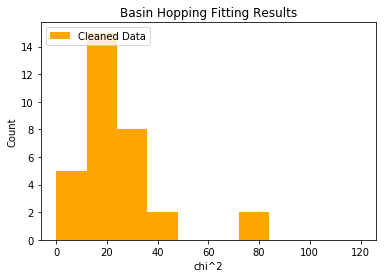

In [8]:
#chi2_with_noise = {'Nelder-Mead':[],'Powell':[],'CG':[],'BFGS':[],'L-BFGS-B':[],'TNC':[],'COBYLA':[],'SLSQP':[]}
chi2_with_noise = {'Nelder-Mead':[]}
chi2_without_noise = {'Nelder-Mead':[]}
time_list_with_noise = {'Nelder-Mead':[]}
time_list_without_noise = {'Nelder-Mead':[]}
methods = ['Nelder-Mead']

for i in range(len(good_event)):
    try:
        evt_ID = good_event[i]
        dataset_name = '/clean'
        evt_full = full[dataset_name]
        xyzs_h5 = evt_full[str(evt_ID)]

        xyzs = np.array(xyzs_h5)

        #delete the points which are farther away from the center of the spiral
        del_list = []

        for i in range(len(xyzs)):
            if (xyzs[i,6]) > 40.0:
                del_list.append(i)
            elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
                del_list.append(i)
            elif (xyzs[i][5] < 2.0): 
                del_list.append(i)         
        cut_xyzs = np.delete(xyzs,del_list,axis=0)

        xy = xyzs[:, 0:2]
        xy_C = np.ascontiguousarray(xy, dtype=np.double)
        cx, cy = pytpc.cleaning.hough_circle(xy_C)

        cut_xy = cut_xyzs[:, 0:2]
        cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
        cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

        uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
        uvw_values = uvw.values
        uvw_sorted = uvw.sort_values(by='w', ascending=True)
        prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
        prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
        ctr0 = mcfitter.guess_parameters(prefit_res)
        exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
        exp_hits = np.zeros(10240)
        for a, p in uvw[['a', 'pad']].values:
            exp_hits[int(p)] = a

        cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
        cut_uvw_values = cut_uvw.values
        cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
        cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
        cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
        cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
        cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
        cut_exp_hits = np.zeros(10240)
        for a, p in cut_uvw[['a', 'pad']].values:
            cut_exp_hits[int(p)] = a

        minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

        def f(y):
            ctr = np.zeros([1,6])
            ctr[0] = y
            chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
            return sum(chi_result[0])
        eps = np.sqrt(np.finfo(np.float).eps)
        def jacobian(x):
            return scipy.optimize.approx_fprime(x,f,eps)

        def cut_f(y):
            ctr = np.zeros([1,6])
            ctr[0] = y
            chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
            return sum(chi_result[0])
        eps = np.sqrt(np.finfo(np.float).eps)
        def cut_jacobian(x):
            return scipy.optimize.approx_fprime(x,cut_f,eps)

        i = 1
        def callbackF(x, f, accept):
            global i
            print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
            i += 1

        j = 1
        def cut_callbackF(x, f, accept):
            global j
            print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],f))
            j += 1

        for a in range(len(methods)):
            #fitting using different local methods
            method = methods[a]
            #fitting original data
            t0 = time.time()
            results = scipy.optimize.basinhopping(f,ctr0, niter=15, T=0.01, stepsize=0.05, minimizer_kwargs={"method": method})
            t1 = time.time()
            time_list_with_noise[method].append(t1-t0)
            if np.isnan(results.fun) != True:
                chi2_with_noise[method].append(results.fun)
            print('Basinhopping (with noise) event '+str(evt_ID)+' with '+str(method)+' method: '+str(t1-t0)+' seconds')
            print('chi2 value: '+str(results.fun))
            #fitting cleaned data
            t3 = time.time()
            cut_results = scipy.optimize.basinhopping(cut_f,cut_ctr0, niter=15, stepsize=0.05,T=0.01, minimizer_kwargs={"method": method})
            t4 = time.time()
            time_list_without_noise[method].append(t4-t3)
            if np.isnan(cut_results.fun) != True:
                chi2_without_noise[method].append(cut_results.fun)
            print('Basinhopping (without noise) event '+str(evt_ID)+' with '+str(method)+' method: '+str(t4-t3)+' seconds')
            print('chi2 value: '+str(cut_results.fun))
    except Exception:
        continue
        
for a in range(len(methods)):
    method = methods[a]
    print("average time with noise for "+method+": "+str(sum(time_list_with_noise[method]) / float(len(time_list_with_noise[method])))+" seconds")
    print("average time without noise for "+method+": "+str(sum(time_list_without_noise[method]) / float(len(time_list_without_noise[method])))+" seconds")
    print('chi2 value (with noise) for '+method+": "+str(sum(chi2_with_noise[method]) / float(len(chi2_with_noise[method]))))
    print('chi2 value (without noise) for '+method+": "+str(sum(chi2_without_noise[method]) / float(len(chi2_without_noise[method]))))


#histograms
for i in chi2_with_noise:
    plt.hist(chi2_with_noise[i], label="Original Data", color='blue', bins=10,range=(0,120))
    plt.title('Basin Hopping Fitting Results')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('Count')
plt.show()


for i in chi2_without_noise:
    plt.hist(chi2_without_noise[i], label="Cleaned Data", color='orange', bins=10,range=(0,120))
    plt.title('Basin Hopping Fitting Results')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('Count')
plt.show()

for i in chi2_without_noise:
    plt.hist(chi2_without_noise[i], label="Cleaned Data", color='orange', bins=10,range=(0,120))
    plt.title('Basin Hopping Fitting Results')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('Count')
plt.show()

In [ ]:
for i in chi2_with_noise:
    plt.hist(chi2_with_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basin Hopping - Original Data')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
    plt.show()


for i in chi2_without_noise:
    plt.hist(chi2_without_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basin Hopping - Cleaned Data')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
    plt.show()
    
for i in chi2_without_noise:    
    
    plt.title('Basin Hopping - Cleaned Data')    
    plt.hist(chi2_with_noise[i], label=i, bins=10, color='blue',range=(0,120))
    plt.hist(chi2_without_noise[i], label=i, bins=10, color='orange',range=(0,120))
    plt.xlabel('chi^2')
    plt.ylabel('Count')
    plt.legend(loc=2)
    plt.show()